In [63]:
!pip install pennylane qiskit qiskit_machine_learning imblearn plotly seaborn pennylane-qiskit pylatexenc


from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE

# classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

from time import time
from datetime import datetime
import matplotlib.cm as cm
from scipy.spatial.distance import cdist

from datetime import datetime
from joblib import Parallel, delayed

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import jax;

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)

In [64]:
import pennylane as qml
import qiskit
print(qml.__version__)
print(qiskit.__version__)
import pennylane_qiskit
print(pennylane_qiskit.__version__)

0.36.0
1.1.0
0.36.0


In [65]:
# prompt: import labels.csv and features.csv and concat them into df

import pandas as pd
labels_df = pd.read_csv('/kaggle/input/heart-disease-preprocessed-data/labels.csv')
features_df = pd.read_csv('/kaggle/input/heart-disease-preprocessed-data/features.csv')

df = pd.concat([features_df, labels_df], axis=1)
df.head()


,Age,Sex,ChestPainType_NAP,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_TA,RestingBP,Cholesterol,FastingBS,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down,HeartDisease
0,65.0,0.0,1.0,0.0,0.0,0.0,140.0,417.0,1.0,1.0,0.0,0.0,157.0,0.0,0.8,1.0,0.0,0.0,0
1,61.0,1.0,0.0,1.0,0.0,0.0,105.0,0.0,1.0,0.0,1.0,0.0,110.0,1.0,1.5,1.0,0.0,0.0,1
2,66.0,1.0,0.0,1.0,0.0,0.0,112.0,212.0,0.0,1.0,0.0,0.0,132.0,1.0,0.1,1.0,0.0,0.0,0
3,41.0,1.0,1.0,0.0,0.0,0.0,112.0,250.0,0.0,0.0,1.0,0.0,179.0,0.0,0.0,1.0,0.0,0.0,1
4,37.0,1.0,1.0,0.0,0.0,0.0,130.0,194.0,0.0,0.0,1.0,0.0,150.0,0.0,0.0,1.0,0.0,0.0,0


In [66]:
df.shape

(918, 19)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    float64
 1   Sex                918 non-null    float64
 2   ChestPainType_NAP  918 non-null    float64
 3   ChestPainType_ASY  918 non-null    float64
 4   ChestPainType_ATA  918 non-null    float64
 5   ChestPainType_TA   918 non-null    float64
 6   RestingBP          918 non-null    float64
 7   Cholesterol        918 non-null    float64
 8   FastingBS          918 non-null    float64
 9   RestingECG_LVH     918 non-null    float64
 10  RestingECG_Normal  918 non-null    float64
 11  RestingECG_ST      918 non-null    float64
 12  MaxHR              918 non-null    float64
 13  ExerciseAngina     918 non-null    float64
 14  Oldpeak            918 non-null    float64
 15  ST_Slope_Up        918 non-null    float64
 16  ST_Slope_Flat      918 non

In [68]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame containing the dataset

# Define X (features) and y (target variable)
X = df.drop(columns=['HeartDisease'])  # Drop the target column
y = df['HeartDisease']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (642, 18)
X_test shape: (276, 18)
y_train shape: (642,)
y_test shape: (276,)


# TTN

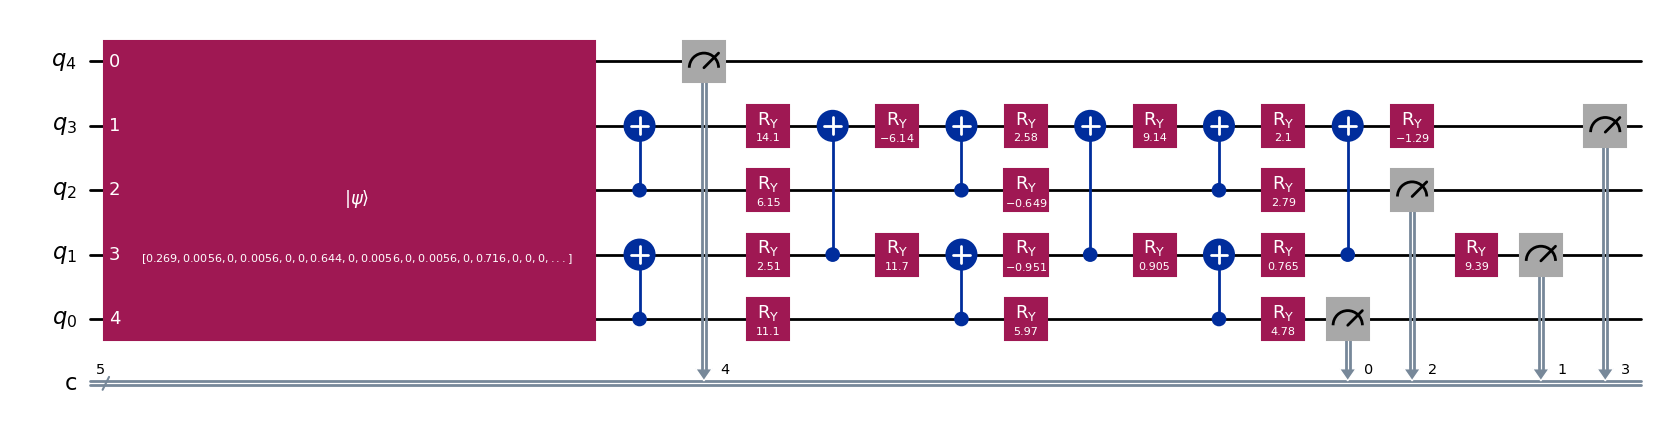

In [69]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, GradientDescentOptimizer, AdamOptimizer, MomentumOptimizer, AdaptiveOptimizer, AdagradOptimizer, RotosolveOptimizer

n_wires = 5
# dev = qml.device("default.qubit", wires=n_wires)
dev = qml.device("qiskit.aer", wires=n_wires) # for drawing only
def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

n_block_wires = 2
n_params_block = 2
n_blocks = qml.TTN.get_n_blocks(range(n_wires),n_block_wires)

### ALL VQC changes take place here #####
@qml.qnode(dev)
def circuit(weights, x):
    qml.AmplitudeEmbedding(x, wires=range(n_wires), normalize=True, pad_with=True)
    for w in weights:
        qml.TTN(range(n_wires),n_block_wires,block, n_params_block, w)
        #print(w)
    #print(x)

    return qml.expval(qml.PauliZ(1))


def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)


np.random.seed(0)
num_layers = 3
weights_init = 2*np.pi * np.random.randn(num_layers,n_blocks, n_params_block, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

circuit(weights_init,np.asarray(X_train.iloc[0]))
dev._circuit.draw('mpl', plot_barriers=True, reverse_bits=True)

In [70]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, GradientDescentOptimizer, AdamOptimizer, MomentumOptimizer, AdaptiveOptimizer, AdagradOptimizer, RotosolveOptimizer

n_wires = 5
dev = qml.device("default.qubit", wires=n_wires)
# dev = qml.device("qiskit.aer", wires=n_wires) # for drawing only

def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

n_block_wires = 2
n_params_block = 2
n_blocks = qml.TTN.get_n_blocks(range(n_wires),n_block_wires)

### ALL VQC changes take place here #####
@qml.qnode(dev)
def circuit(weights, x):
    qml.AmplitudeEmbedding(x, wires=range(n_wires), normalize=True, pad_with=True)
    for w in weights:
        qml.TTN(range(n_wires),n_block_wires,block, n_params_block, w)
        #print(w)
    #print(x)

    return qml.expval(qml.PauliZ(1))


def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

np.random.seed(0)
num_layers = 3
weights_init = 2*np.pi * np.random.randn(num_layers, n_blocks, n_params_block, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[11.08386778  2.51426189]
  [ 6.14959212 14.07994722]
  [11.73421292 -6.14041802]]

 [[ 5.96958159 -0.95100539]
  [-0.64854317  2.57986647]
  [ 0.90505245  9.13746993]]

 [[ 4.78174105  0.76450668]
  [ 2.78887494  2.09653763]
  [ 9.38757568 -1.28904739]]] 0.0


In [71]:
for i in weights_init:
    print(i[0])

[11.08386778  2.51426189]
[ 5.96958159 -0.95100539]
[4.78174105 0.76450668]


In [72]:
ysm_train = np.where(y_train < 1, -1, y_train)
ysm_test = np.where(y_test < 1, -1, y_test)

In [73]:
ysm_train = ysm_train.astype(np.float32)
ysm_test = ysm_test.astype(np.float32)

In [74]:
ysm_test.dtype

dtype('float32')

In [75]:
from sklearn.utils import shuffle
X,y = shuffle(X_train, ysm_train, random_state=0)

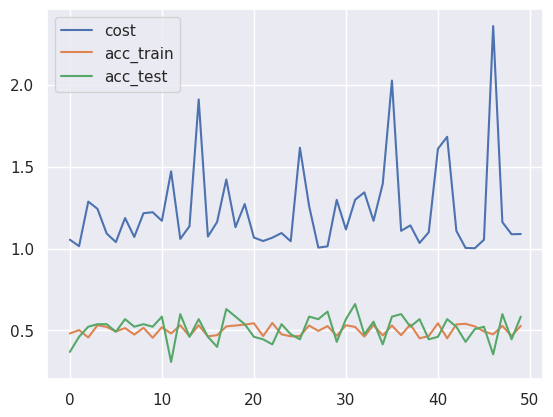

Iter:    50 | Cost: 1.0888163 | Acc train: 0.5285962 | Acc validation: 0.5846154 
[[[  6.21987258  -1.13835994]
  [ -0.07861409   1.32876087]
  [ 23.62801888  -1.29461273]]

 [[ -2.27055436  -8.32496764]
  [  0.0335044    5.24468824]
  [-19.48984609  16.53908044]]

 [[  4.78174105  11.41619587]
  [  2.78887494  11.28014724]
  [ 24.41685801  -1.28904739]]]


In [76]:
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
clear_output(wait=False)

opt = NesterovMomentumOptimizer(0.4)
batch_size = 16 # if the dataset is short, try to decrease the batch size

num_data = len(ysm_train)
num_train = 0.9
# train the variational classifier
weights = weights_init
bias = bias_init
print()

cost_g = []
acc_train = []
acc_test = []
plt.show()
for it in range(50):
    X_train_70, X_test_30, y_train_70, y_test_30 =train_test_split(np.asarray(X), np.asarray(y), train_size=num_train, test_size=1.0-num_train, shuffle=True)
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train_70), (batch_size,))
    feats_train_batch = X_train_70[batch_index]
    Y_train_batch = y_train_70[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train_70]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_test_30]
    # Compute accuracy on train and validation set
    acc_tra = accuracy(y_train_70, predictions_train)
    acc_val = accuracy(y_test_30, predictions_val)
    cost_train = cost(weights, bias, X_train_70, y_train_70)
    cost_g.append(cost_train)

    acc_train.append(acc_tra)
    acc_test.append(acc_val)

    clear_output(wait=True)
    plt.plot(cost_g,label='cost')
    plt.plot(acc_train,label='acc_train')
    plt.plot(acc_test,label='acc_test')
    plt.legend(['cost','acc_train','acc_test'])
    plt.show()


    print(
         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
         "".format(it + 1, cost_train, acc_tra, acc_val)
     )
    print(weights)

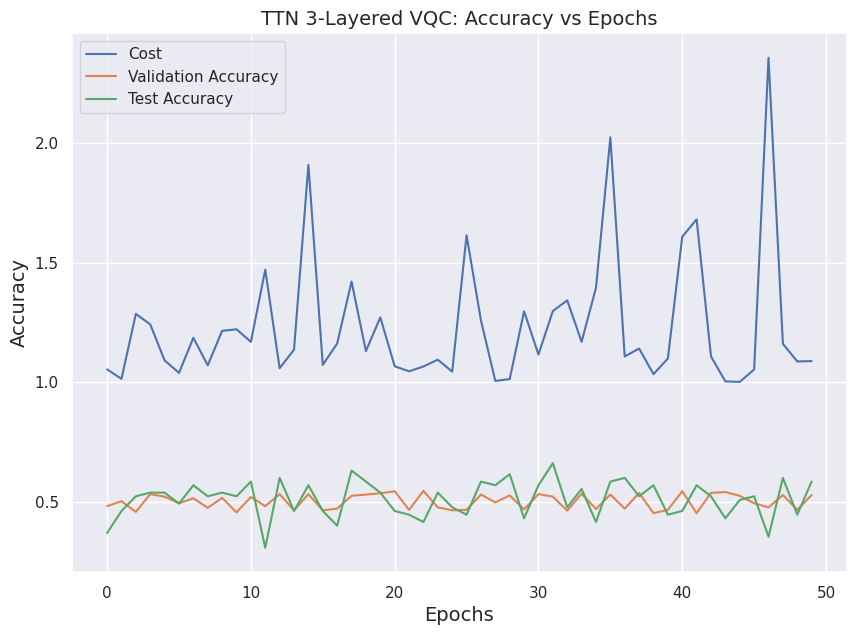

In [77]:
plt.figure(figsize=[10,7])
plt.plot(cost_g,label='Cost')
plt.plot(acc_train,label='Train Accuracy')
plt.plot(acc_test,label='Validation Accuracy')
plt.title("TTN 3-Layered VQC: Accuracy vs Epochs",fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend(['Cost','Validation Accuracy','Test Accuracy'])
plt.show()

In [78]:
x_test = []
for x in X_test.values.tolist():
    if sum(x) == 0:
        x[0]=1
    x_test.append( x/ np.linalg.norm(x))

y_pred = [np.sign(variational_classifier(weights, bias, f)) for f in x_test]
y_test_pred = []
for i in y_pred:
    if i < 0:
        y_test_pred.append(-1)
    else:
        y_test_pred.append(1)
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(ysm_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ysm_test, y_test_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ysm_test, y_test_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ysm_test, y_test_pred)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(ysm_test, y_test_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(ysm_test, y_test_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
test_matrix = confusion_matrix(ysm_test, y_test_pred)
print(test_matrix)


from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, matthews_corrcoef

# Compute MCC
mcc = matthews_corrcoef(ysm_test, y_test_pred)

# Print AUC, Kappa, and MCC
print("MCC:", mcc)

from sklearn.metrics import classification_report
classes=['Normal','Heart Disease']
print(classification_report(ysm_test, y_test_pred, target_names=classes))

Accuracy: 0.594203
Precision: 0.594203
Recall: 1.000000
F1 score: 0.745455
Cohens kappa: 0.000000
ROC AUC: 0.500000
[[  0 112]
 [  0 164]]
MCC: 0.0
               precision    recall  f1-score   support

       Normal       0.00      0.00      0.00       112
Heart Disease       0.59      1.00      0.75       164

     accuracy                           0.59       276
    macro avg       0.30      0.50      0.37       276
 weighted avg       0.35      0.59      0.44       276



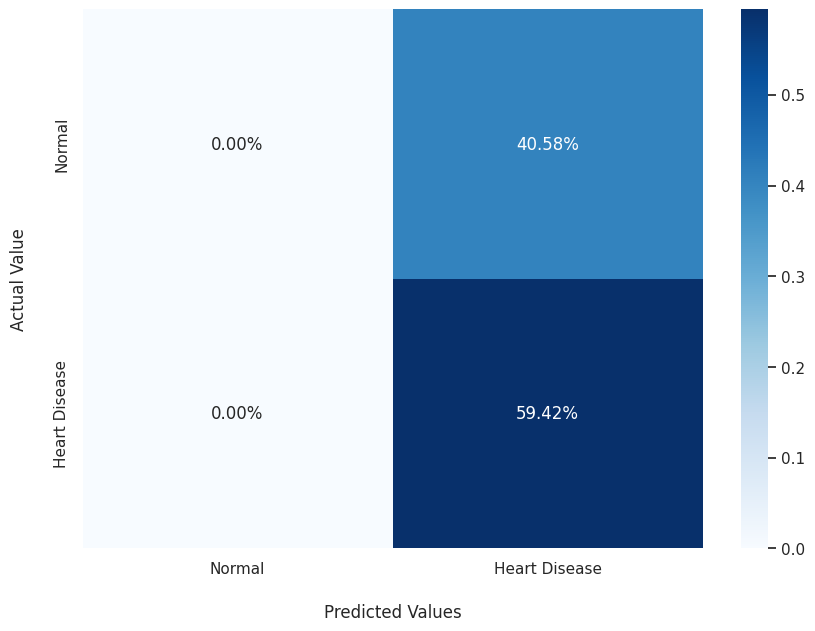

In [79]:
plt.figure(figsize=[10,7])
ax = sns.heatmap(test_matrix/np.sum(test_matrix), annot=True, cmap='Blues', fmt='0.2%')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Value\n');

ax.xaxis.set_ticklabels(['Normal','Heart Disease'])
ax.yaxis.set_ticklabels(['Normal','Heart Disease'])

## Display the visualization of the Confusion Matrix.
plt.show()